In [244]:
import pandas as pd

df = pd.read_csv('response.csv') 
df = df.fillna('')
df['response']=df.iloc[:,3]+df.iloc[:,5]+df.iloc[:,6]
df['issue'] = df.iloc[:,1]
df['symptom'] = df.iloc[:,2] + df.iloc[:,4]
subset = df.iloc[:,-3:]
subset

,response,issue,symptom
0,my brakes make a noise whenever I try to stop,Brakes,Car makes grinding noise
1,super frustrating every time I start my car it...,Starter,Car starts then stops
2,I can't open the damn door to my car,Other,
3,I turn the key and nothing happens,Starter,Car doesn't start
4,Car doesn't always start when it's low on blin...,Starter,Car doesn't start
...,...,...,...
104,my breaks are faulty.,Brakes,"Car brakes, but then brakes disengage"
105,my lights do not work,Other,
106,I try to start the engine only to find that th...,Starter,Car doesn't start
107,The driver side window auto function does not ...,Other,


In [245]:
import markovify
import codecs

In [246]:
def train_markov_type(data, issue):
    return markovify.Text(data[data["issue"] == issue].response, retain_original=False, state_size=2)

def make_sentence(model, length=200):
    return model.make_short_sentence(length, max_overlap_ratio = .7, max_overlap_total=15)

other_model = train_markov_type(subset, "Other")
brakes_model = train_markov_type(subset, "Brakes")
starter_model = train_markov_type(subset, "Starter")

In [247]:
make_sentence(other_model)

'Fuel economy has gotten very bad.'

In [248]:
make_sentence(brakes_model)

'It stops if I push it really far, but I have to brake again.'

In [249]:
make_sentence(starter_model)

'Alternator is faulty'

We can combine these models with relative weights

In [250]:
compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])

In [251]:
for i in range(20):
    print(make_sentence(compound_model))

Car doesn't always start when it's low on blinker fluid
If I knew what the problem was, I wouldn't be on some website, I'd be fixing it!!
I have the button pushed in and the fan is running full blast.
I can't open the damn door to my car is now a pile of ashes.
Just that odd clicking noise....
Steering wheel shakes uncontrollably when I accelerate above 60 mph
I'm having an issue with fuel injection sensor or pressure.
Shuttering when accelerating
The seat belt itself on the the fourth time.
my brakes make a noise whenever I try to set it at anything other than MAX COOL, it defaults to full blast heat or full blast cooling.
I'm having an issue with fuel injection sensor or pressure.
I was working on the menu to return to my car it just stops again, what is wrong!
But the car evaluated.
The driver side window auto function does not happen at very high speeds, but generally tolerable at or above 80.
sometimes, it won't turn on, but it takes more force to stop
My car is wrecking perfectly

In [252]:
import numpy
def generate_cases(models, weights=None):
    if weights is None:
        weights = [1] * len(models)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]


    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    
    while True:
        yield (make_sentence(choose_model()))
            

In [253]:
t = generate_cases([other_model, brakes_model, starter_model], [3,4,4])

In [254]:
[next(t) for i in range(100)]

['It sputters for a few seconds and then nothing happens.',
 'When I put the car evaluated.',
 'My car does not turn over',
 "Car makes a lot noise and doesn't fully stop when we hit the break.",
 "Sometimes the car doesn't start and it seems like the battery is dead, but I have to press the ignition three times before the car would make a click click clicking sound - maybe a dead battery?",
 'When I try to start it.',
 'When I tried to drive, the car does not stop',
 'It takes a long time before finally engaging and actually turning on.',
 'I have to press the ignition button at least twice before my car it just stops again, what is wrong!',
 "It's rather a periodic deep sound when breaking.",
 'When I try to start the engine doesn’t power up',
 'Leak of a clear, cloudy, oil like substance in the car.',
 'The windshield has a lot of black smoke and acrid smell.',
 "Brakes might be getting old because car doesn't seem to stop as quickly as it used to",
 'If I pump the brake pedal',
 "I

Checking for similarity (slow)

<ipython-input-255-42ca54a62509>:14: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if m < doc.similarity(doc1):
<ipython-input-255-42ca54a62509>:15: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models

Mean similarity: 0.7900352396541175


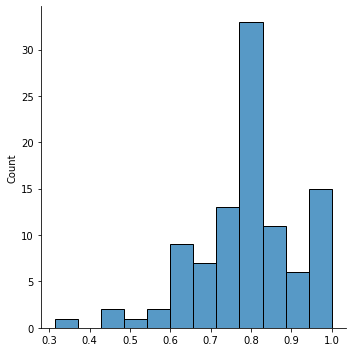

In [255]:
import spacy
nlp = spacy.load('en_core_web_sm')

dt_b = subset["response"]
dt_a = [next(t) for i in range(100)]

import numpy as np
a = []
for sentence in dt_a:
    doc = nlp(sentence)
    m = 0
    for sentence1 in dt_b:
        doc1 = nlp(sentence1)
        if m < doc.similarity(doc1):
            m = doc.similarity(doc1)
    a.append(m)
        
print("Mean similarity: " + str(np.array(a).mean()))

import seaborn as sns
sns.displot(a)

In [256]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [257]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

Tue Mar  9 11:33:38 2021    generatestats

         303366 function calls (278038 primitive calls) in 0.158 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.002    0.000    0.146    0.000 <ipython-input-246-3e3ab942a540>:4(make_sentence)
     2000    0.002    0.000    0.009    0.000 <ipython-input-252-5f1382f3447f>:13(choose_model)
     2000    0.001    0.000    0.157    0.000 <ipython-input-252-5f1382f3447f>:2(generate_cases)
        1    0.001    0.001    0.158    0.158 <ipython-input-256-801ca619797e>:3(timing)
        1    0.000    0.000    0.158    0.158 <string>:1(<module>)
    64057    0.017    0.000    0.024    0.000 chain.py:10(accumulate)
    27366    0.019    0.000    0.125    0.000 chain.py:112(gen)
     2038    0.005    0.000    0.130    0.000 chain.py:125(walk)
    27366    0.069    0.000    0.106    0.000 chain.py:96(move)
     2038    0.001    0.000    0.002    0.000 text.py:120(word_join)
    